<a href="https://colab.research.google.com/github/prabal5ghosh/research-project-on-physics-informed-machine-learning-on-transcriptomics-data/blob/main/pinn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras import layers

print(tf.__version__)
print(keras.__version__)


In [5]:
import torch
import torch.nn as nn

class ODENet(nn.Module):
    def __init__(self):
        super(ODENet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 5)  # Output layer with 5 neurons
        )

    def forward(self, t):
        return self.net(t)


In [6]:
def ode_loss(model, t, y_true):
    y_pred = model(t)

    # Reshape y_pred and y_true to have the same shape
    y_pred = y_pred.transpose(0, 1)  # Transpose to shape (5, 3)

    # Data loss
    loss_data = torch.mean((y_pred - y_true)**2)

    # Physics loss (approximating derivatives)
    dt = 0.01
    t_prev = t - dt
    t_next = t + dt
    y_prev = model(t_prev)
    y_next = model(t_next)
    dy_dt = (y_next - y_prev) / (2 * dt)

    # Define your ODE here (example: dy/dt = -y)
    # NOTE: You may need to adjust this part to match your actual ODE
    ode_residual = dy_dt + y_pred.transpose(0, 1)  # Transpose back for physics loss calculation
    loss_physics = torch.mean(ode_residual**2)

    return loss_data + loss_physics

In [7]:
import numpy as np

# Prepare data
data = np.array([
    [0.906000416, 0.906000416, 0.906000416],
    [-0.44796003, -0.560154646, -5.091964284],
    [1.778358524, 0, 0],
    [0, 1.175149691, 0],
    [0.055374646, 0.098434984, -0.101756864]
])
t_data = torch.tensor([1, 2, 4], dtype=torch.float32).unsqueeze(1)
y_data = torch.tensor(data, dtype=torch.float32)

model = ODENet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10000):
    optimizer.zero_grad()
    loss = ode_loss(model, t_data, y_data)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 2.4764602184295654
Epoch 1000, Loss: 0.0038833096623420715
Epoch 2000, Loss: 6.600055348826572e-05
Epoch 3000, Loss: 5.891843102290295e-08
Epoch 4000, Loss: 8.672450348967686e-05
Epoch 5000, Loss: 1.5923907525916547e-08
Epoch 6000, Loss: 7.26092412151047e-06
Epoch 7000, Loss: 1.075715431397839e-06
Epoch 8000, Loss: 2.9551692648510652e-08
Epoch 9000, Loss: 9.005005267681554e-06


In [8]:
y_data[1, :].detach().numpy()

array([-0.44796002, -0.5601546 , -5.0919642 ], dtype=float32)

(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([0.9060, 0.9060, 0.9060]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([-0.4480, -0.5602, -5.0920]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([1.7784, 0.0000, 0.0000]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([0.0000, 1.1751, 0.0000]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([ 0.0554,  0.0984, -0.1018]))


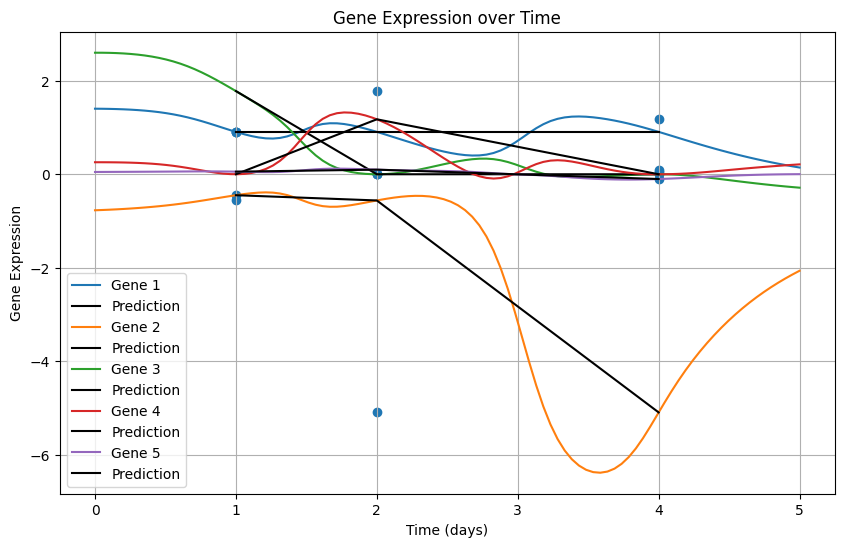

In [9]:
import matplotlib.pyplot as plt

t_plot = torch.linspace(0, 5, 100).unsqueeze(1)
y_plot = model(t_plot).detach().numpy()

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(t_plot, y_plot[:, i], label=f"Gene {i+1}")
    print((t_data.detach().numpy(), y_data[i, ]))
    plt.plot(t_data.detach().numpy(), y_data[i, ].detach().numpy(), label='Prediction', color='black')


# Repeat t_data for each gene and flatten y_data
t_scatter = np.repeat(t_data.numpy().squeeze(), y_data.shape[0])
y_scatter = y_data.numpy().flatten()
# plt.plot(t_data, y_data, label='Prediction', color='blue')


plt.scatter(t_scatter, y_scatter)  # Updated scatter plot
plt.xlabel("Time (days)")
plt.ylabel("Gene Expression")
plt.legend()
plt.title("Gene Expression over Time")
plt.grid(True)
plt.show()

Test Predictions (Predicted):
tensor([[ 9.0571e-01, -4.4782e-01,  1.7780e+00,  1.9413e-04,  5.5473e-02],
        [ 9.0591e-01, -5.6036e-01, -1.5673e-04,  1.1753e+00,  9.8504e-02],
        [ 9.0649e-01, -5.0940e+00,  4.2053e-04, -5.1075e-04, -1.0187e-01]],
       grad_fn=<AddmmBackward0>)

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


<ipython-input-10-63e9ca9cd519>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


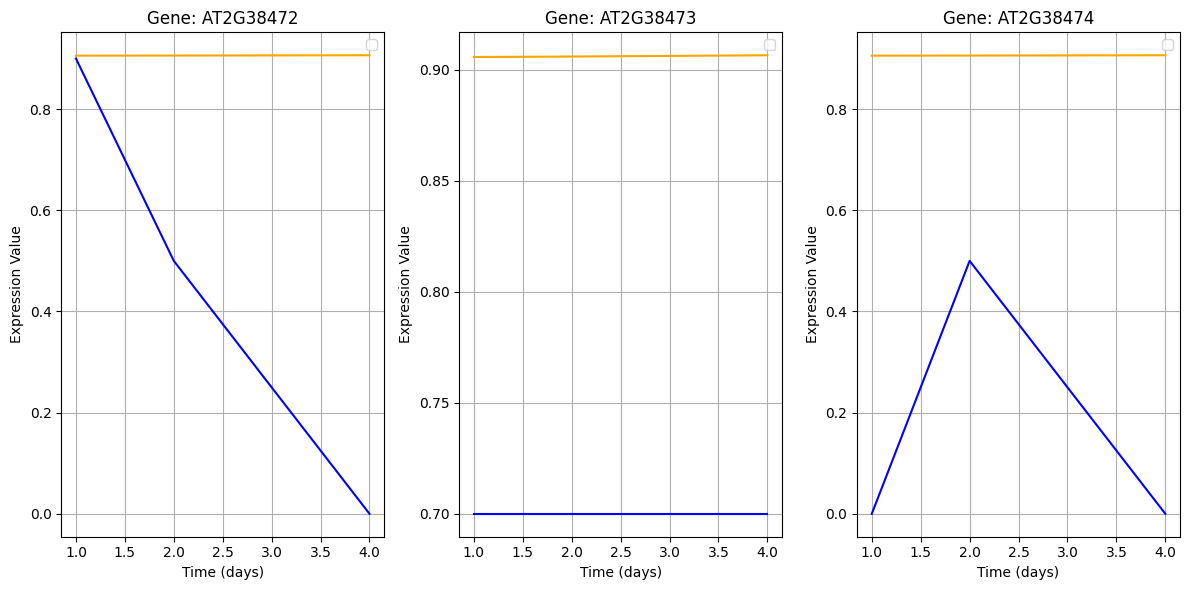

In [10]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)


# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
test_time_points = torch.tensor(test_time_points, dtype=torch.float32, requires_grad=True)
predicted_test_values = model(test_time_points)


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points.detach().numpy(), test_expression_values[i], color="blue")
    plt.plot(test_time_points.detach().numpy(), predicted_test_values[:, 0].detach().numpy(), color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
import tensorflow as tf
import numpy as np

# Data
time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)  # Time in days
expression_values = np.array([
    [0.906000416, 0.906000416, 0.906000416],    # AT2G38470
    [-0.44796003, -0.560154646, -5.091964284],  # AT5G40100
    [1.778358524, 0, 0],                        # AT1G06930
    [0, 1.175149691, 0],                        # AT1G04470
    [0.055374646, 0.098434984, -0.101756864],   # AT5G66730
    [0.505, 0.505, 0.505],                      # AT2G38471
], dtype=np.float32)

# Number of genes
num_genes = expression_values.shape[0]

# Define the PINN model for multiple genes
class MultiGeneODE_PINN(tf.keras.Model):
    def __init__(self, num_genes):
        super(MultiGeneODE_PINN, self).__init__()
        self.num_genes = num_genes
        self.hidden_layers = [tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)]
        self.output_layer = tf.keras.layers.Dense(num_genes)  # Predict x(t) for all genes
        self.k = tf.Variable(tf.random.uniform([num_genes], 0.1, 1.0), trainable=True, dtype=tf.float32)  # Learnable parameters k for each gene

    def call(self, t):
        x = t
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Define loss function
def loss_fn(model, t, x_true):
    t = tf.convert_to_tensor(t, dtype=tf.float32)  # Ensure t is a TensorFlow tensor
    x_pred = model(t)  # Predicted x(t) for all genes

    with tf.GradientTape() as tape:
        tape.watch(t)
        x_t = model(t)  # Recompute x(t) under the tape
    dx_dt = tape.gradient(x_t, t)  # Compute dx/dt for all genes

    k = tf.expand_dims(model.k, axis=0)  # Expand dims to match batch size
    x_steady = tf.constant(expression_values[:, -1], dtype=tf.float32)  # Steady-state values from the last time point
    x_steady = tf.expand_dims(x_steady, axis=0)  # Expand dims to match batch size

    ode_residual = dx_dt + k * (x_t - x_steady)  # Residual for each gene

    # Combined loss: ODE residual + Data fitting
    return tf.reduce_mean(tf.square(ode_residual)) + tf.reduce_mean(tf.square(x_pred - x_true))

# Prepare training
model = MultiGeneODE_PINN(num_genes=num_genes)
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 300
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, time_points, expression_values.T)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Display the learned parameters k
print(f"Learned decay constants k: {model.k.numpy()}")

# Predict x(t) using the trained PINN
predicted_values = model(time_points).numpy()
print("Predicted Values:\n", predicted_values)


Epoch 0, Loss: 6.05186653137207
Epoch 50, Loss: 1.143724799156189
Epoch 100, Loss: 1.1920745372772217
Epoch 150, Loss: 1.0138728618621826
Epoch 200, Loss: 0.9776398539543152
Epoch 250, Loss: 0.9775046706199646
Learned decay constants k: [0.66551054 0.96676075 0.20150219 0.6044624  0.29206    0.2970928 ]
Predicted Values:
 [[ 1.1662149e+00 -2.4085505e+00  1.8166682e+00  2.4941251e-01
   1.9344848e-01  6.5731066e-01]
 [ 1.1853176e+00 -2.4479401e+00  1.1858508e-01  1.1291853e+00
   2.4665527e-01  6.7207789e-01]
 [ 9.0616566e-01 -5.0917544e+00  3.6343932e-04  1.2609176e-05
  -1.0146147e-01  5.0513846e-01]]


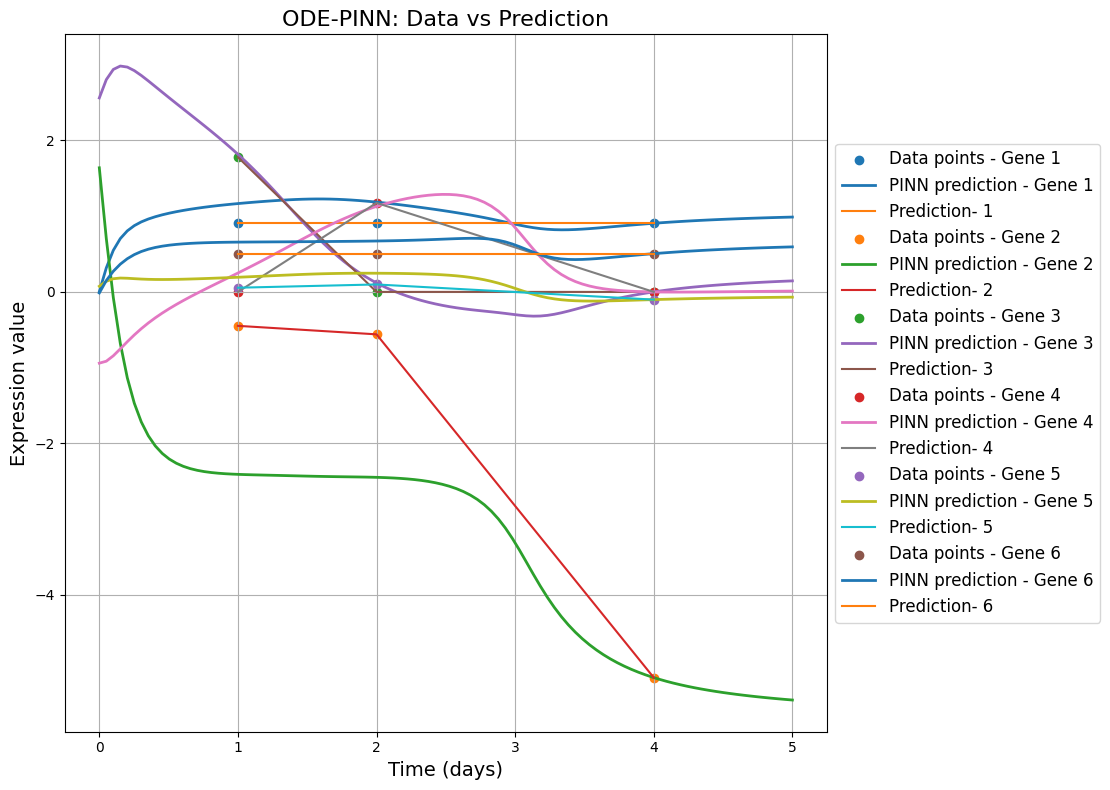

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a range of time points for a smooth curve
t_smooth = np.linspace(0, 5, 100).reshape(-1, 1)

# Get predictions for the smooth curve (replace `model` with your trained model)
x_smooth = model(t_smooth).numpy()

# Create a large figure
plt.figure(figsize=(14, 8))

# Loop through each gene and plot its data and prediction
for i in range(num_genes):
    plt.scatter(
        time_points,
        expression_values[i],
        label=f'Data points - Gene {i+1}',
        marker='o',
    )
    plt.plot(
        t_smooth,
        x_smooth[:, i],
        label=f'PINN prediction - Gene {i+1}',
        linewidth=2,
    )

    plt.plot(time_points, expression_values[i, ], label=f'Prediction- {i+1}')

# Labels, title, and grid
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Expression value', fontsize=14)
plt.title('ODE-PINN: Data vs Prediction', fontsize=16)
plt.grid(True)

# Adjust legend: Move it outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Make space for the legend on the right

# Show the plot
plt.show()


Test Predictions (Predicted):
tf.Tensor(
[[ 1.1662149e+00 -2.4085505e+00  1.8166682e+00  2.4941251e-01
   1.9344848e-01  6.5731066e-01]
 [ 1.1853176e+00 -2.4479401e+00  1.1858508e-01  1.1291853e+00
   2.4665527e-01  6.7207789e-01]
 [ 9.0616566e-01 -5.0917544e+00  3.6343932e-04  1.2609176e-05
  -1.0146147e-01  5.0513846e-01]], shape=(3, 6), dtype=float32)

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


<ipython-input-22-b2c4d37843c8>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


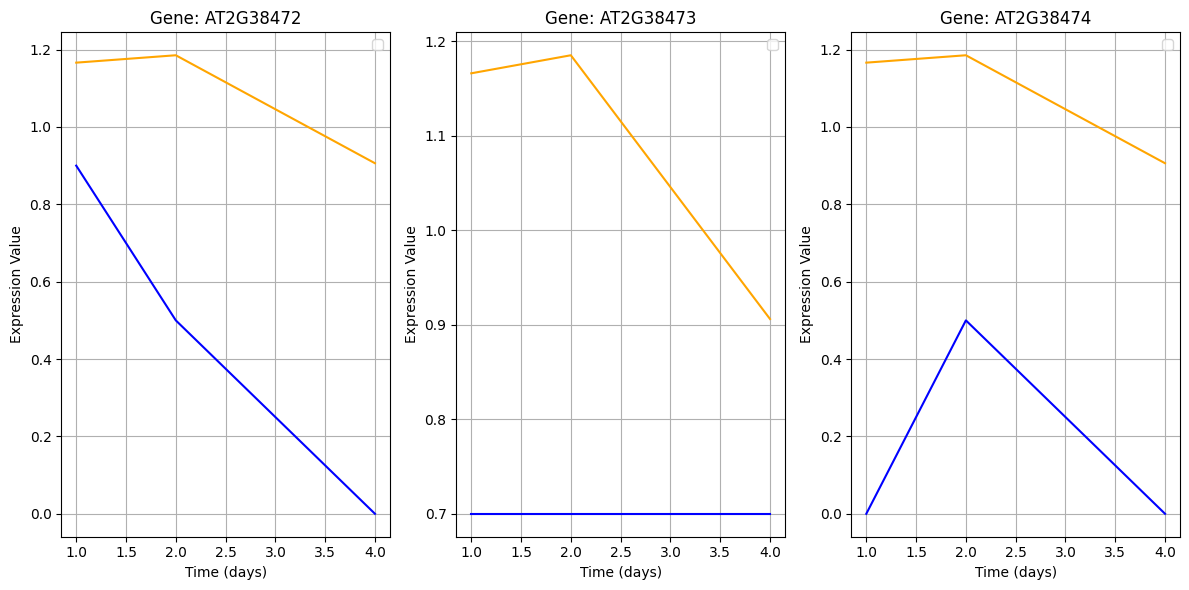

In [22]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)


# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
# test_time_points = torch.tensor(test_time_points, dtype=torch.float32, requires_grad=True)
predicted_test_values = model(test_time_points)


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points, test_expression_values[i], color="blue")
    plt.plot(test_time_points, predicted_test_values[:, 0], color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [23]:
model.summary()

Model: "multi_gene_ode_pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (3, 50)                     │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (3, 50)                     │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (3, 50)                     │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (3, 50)                     │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (3, 50)                     │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (3, 6)                      │             306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,606 (41.43 KB)

 Trainable params: 10,606 (41.43 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.k

<tf.Variable 'Variable:0' shape=(6,) dtype=float32, numpy=
array([0.66551054, 0.96676075, 0.20150219, 0.6044624 , 0.29206   ,
       0.2970928 ], dtype=float32)>

Epoch 0, Loss: 7.194990
Epoch 500, Loss: 0.000148
Epoch 1000, Loss: 0.000000
Epoch 1500, Loss: 0.000000
Epoch 2000, Loss: 0.000153
Epoch 2500, Loss: 0.000000
Epoch 3000, Loss: 0.000000
Epoch 3500, Loss: 0.000000
Epoch 4000, Loss: 0.000000
Epoch 4500, Loss: 0.000000
Estimated parameters:
k: -0.234969, c: -0.080620


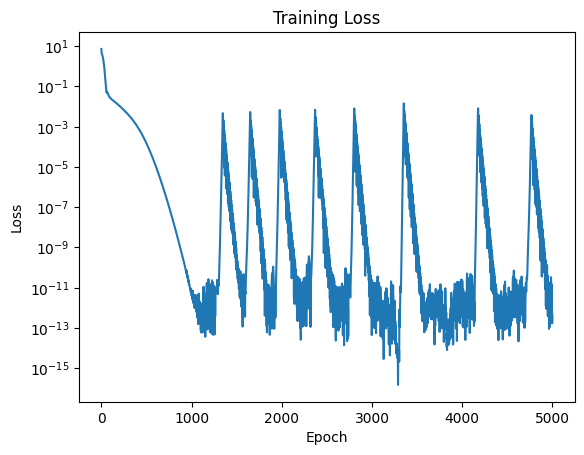

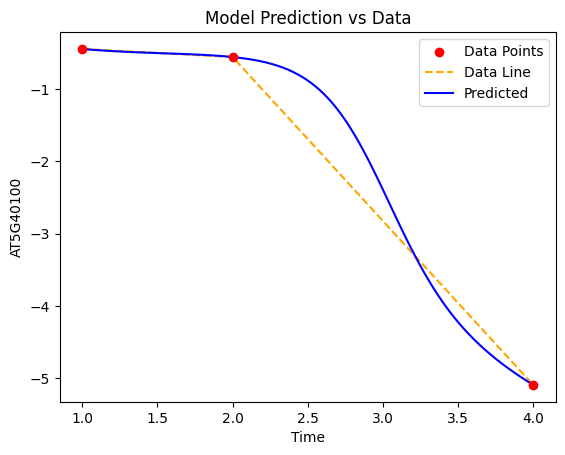

In [44]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Given data
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)
data_values = torch.tensor([-0.44796, -0.56015, -5.09196], dtype=torch.float32).view(-1, 1)

# Neural Network for PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        # Parameters to estimate
        self.k = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Physics-Informed Loss Function
def loss_function(model, t, y_true):
    # Data loss
    y_pred = model(t)
    data_loss = torch.mean((y_pred - y_true) ** 2)

    # Physics loss
    # y_pred.requires_grad = True
    t = t.clone().requires_grad_(True)
    y_pred = model(t)
    dy_dt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    physics_loss = torch.mean((dy_dt + model.k * y_pred - model.c) ** 2)
    return data_loss + physics_loss

# Model, Optimizer, and Training Setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, time_points, data_values)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Results
print("Estimated parameters:")
print(f"k: {model.k.item():.6f}, c: {model.c.item():.6f}")

# Plot Loss History
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot Prediction vs Data
# Plot given data points
plt.scatter(time_points.numpy(), data_values.numpy(), label='Data Points', color='red', zorder=5)
plt.plot(time_points.numpy(), data_values.numpy(), label='Data Line', color='orange', linestyle='--')

# Plot model prediction
t_fine = torch.linspace(1, 4, 100).view(-1, 1)
y_pred_fine = model(t_fine).detach().numpy()
plt.plot(t_fine.numpy(), y_pred_fine, label='Predicted', color='blue')

plt.xlabel('Time')
plt.ylabel('AT5G40100')
plt.title('Model Prediction vs Data')
plt.legend()
plt.show()


Test Predictions (Predicted):
tensor([[-0.4480],
        [-0.5602],
        [-5.0920]], grad_fn=<AddmmBackward0>)

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


<ipython-input-45-eb27e72f671a>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


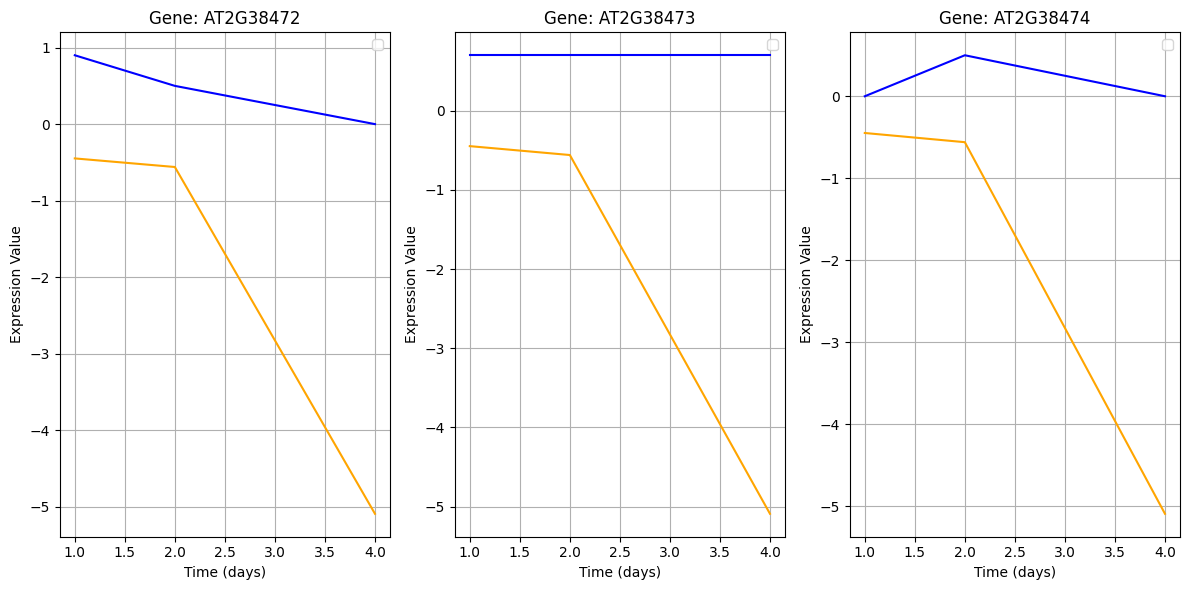

In [45]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)
# test_expression_values = torch.tensor(test_expression_values, dtype=torch.float32)

# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
test_time_points = torch.tensor(test_time_points, dtype=torch.float32)
predicted_test_values = model(test_time_points)


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points.detach().numpy(), test_expression_values[i], color="blue")
    plt.plot(test_time_points.detach().numpy(), predicted_test_values[:, 0].detach().numpy(), color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [46]:
model.k

Parameter containing:
tensor(-0.2350, requires_grad=True)

In [47]:
model.c

Parameter containing:
tensor(-0.0806, requires_grad=True)

Epoch 0, Loss: 0.115648
Epoch 500, Loss: 0.000000
Epoch 1000, Loss: 0.000020
Epoch 1500, Loss: 0.000000
Epoch 2000, Loss: 0.000000
Epoch 2500, Loss: 0.000000
Epoch 3000, Loss: 0.000000
Epoch 3500, Loss: 0.000000
Epoch 4000, Loss: 0.000000
Epoch 4500, Loss: 0.000000
Estimated parameters:
k: -0.198697, c: -0.139285


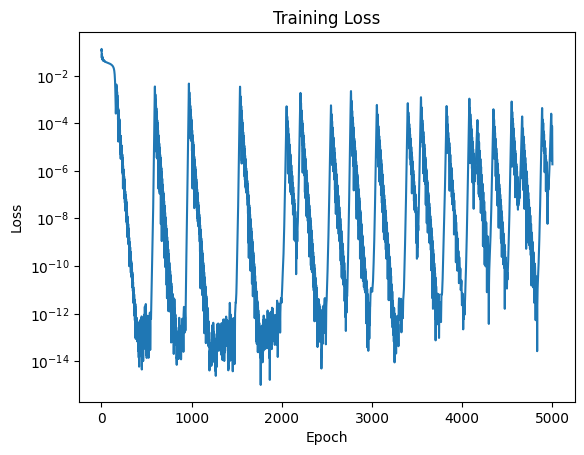

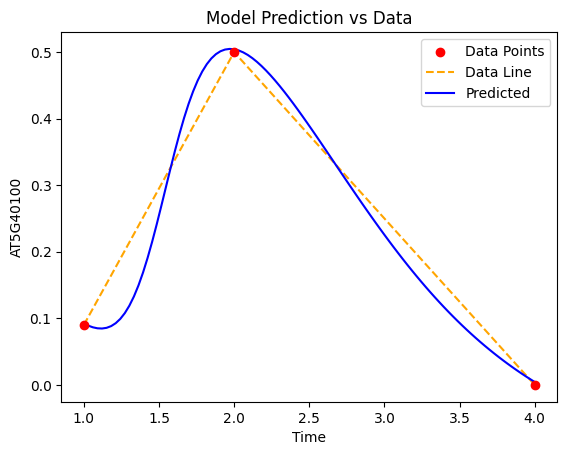

In [48]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Given data
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)
data_values = torch.tensor([.09, 0.5, 0.0], dtype=torch.float32).view(-1, 1)

# Neural Network for PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        # Parameters to estimate
        self.k = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Physics-Informed Loss Function
def loss_function(model, t, y_true):
    # Data loss
    y_pred = model(t)
    data_loss = torch.mean((y_pred - y_true) ** 2)

    # Physics loss
    # y_pred.requires_grad = True
    t = t.clone().requires_grad_(True)
    y_pred = model(t)
    dy_dt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    physics_loss = torch.mean((dy_dt + model.k * y_pred - model.c) ** 2)
    return data_loss + physics_loss

# Model, Optimizer, and Training Setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, time_points, data_values)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Results
print("Estimated parameters:")
print(f"k: {model.k.item():.6f}, c: {model.c.item():.6f}")

# Plot Loss History
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot Prediction vs Data
# Plot given data points
plt.scatter(time_points.numpy(), data_values.numpy(), label='Data Points', color='red', zorder=5)
plt.plot(time_points.numpy(), data_values.numpy(), label='Data Line', color='orange', linestyle='--')

# Plot model prediction
t_fine = torch.linspace(1, 4, 100).view(-1, 1)
y_pred_fine = model(t_fine).detach().numpy()
plt.plot(t_fine.numpy(), y_pred_fine, label='Predicted', color='blue')

plt.xlabel('Time')
plt.ylabel('AT5G40100')
plt.title('Model Prediction vs Data')
plt.legend()
plt.show()


Test Predictions (Predicted):
tensor([[0.0922],
        [0.5042],
        [0.0044]], grad_fn=<AddmmBackward0>)

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


<ipython-input-49-eb27e72f671a>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


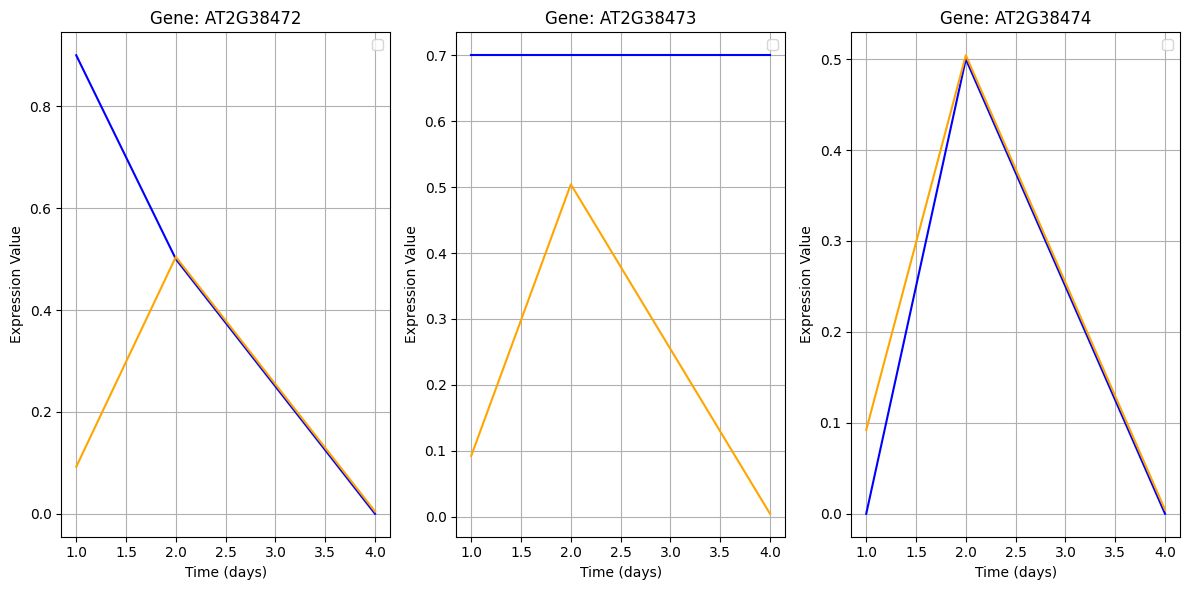

In [49]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)
# test_expression_values = torch.tensor(test_expression_values, dtype=torch.float32)

# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
test_time_points = torch.tensor(test_time_points, dtype=torch.float32)
predicted_test_values = model(test_time_points)


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points.detach().numpy(), test_expression_values[i], color="blue")
    plt.plot(test_time_points.detach().numpy(), predicted_test_values[:, 0].detach().numpy(), color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [50]:
model.k

Parameter containing:
tensor(-0.1987, requires_grad=True)

In [51]:
model.c

Parameter containing:
tensor(-0.1393, requires_grad=True)

Epoch 0, Loss: 10.947571754455566
Epoch 1000, Loss: 7.006573099488378e-11
Epoch 2000, Loss: 3.824012287378942e-12
Epoch 3000, Loss: 5.029456295879697e-10
Epoch 4000, Loss: 7.835240830900148e-05
Epoch 5000, Loss: 3.313338226007545e-08
Epoch 6000, Loss: 2.3807515958651493e-09
Epoch 7000, Loss: 2.9827236858182005e-07
Epoch 8000, Loss: 5.7734785514185205e-05
Epoch 9000, Loss: 2.919989583460847e-06
Learned k_p1: 0.6595672965049744
Learned k_d1: 0.7219230532646179
Learned k_d2: -6.726288847858086e-05


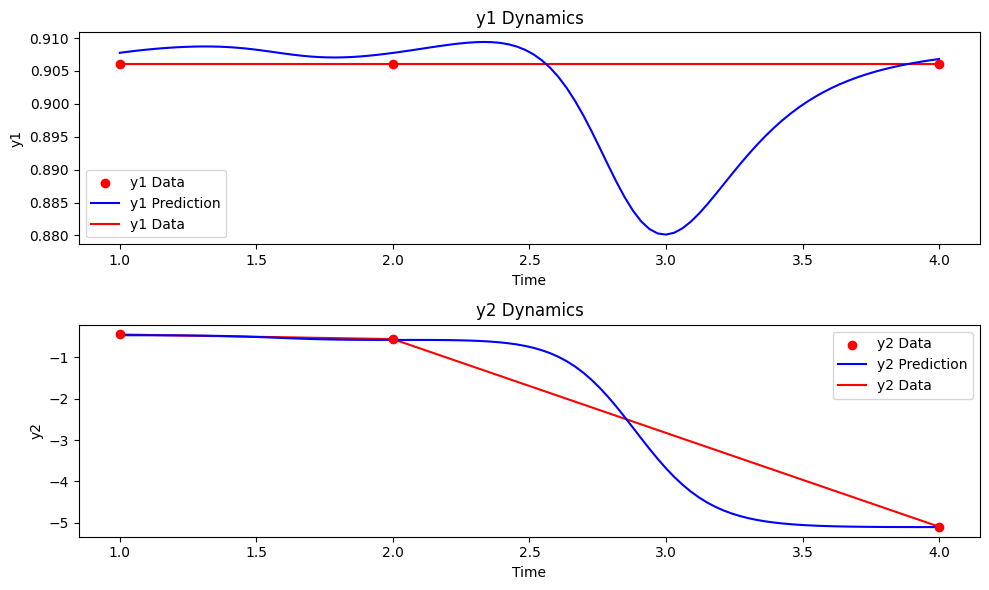

In [52]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)  # Outputs: y1, y2
        )
        # Trainable parameters
        self.k_p1 = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.k_d1 = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.k_d2 = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t)
    y1_pred, y2_pred = y_pred[:, 0], y_pred[:, 1]

    # Compute derivatives
    y1_t = torch.autograd.grad(y1_pred, t, grad_outputs=torch.ones_like(y1_pred), create_graph=True)[0]
    y2_t = torch.autograd.grad(y2_pred, t, grad_outputs=torch.ones_like(y2_pred), create_graph=True)[0]

    # ODE residuals
    ode1 = y1_t - (model.k_p1 - model.k_d1 * y1_pred)
    ode2 = y2_t + model.k_d2 * y2_pred

    # Physics loss
    physics_loss = torch.mean(ode1**2) + torch.mean(ode2**2)

    # Data loss
    data_loss = torch.mean((y1_pred - y_data[:, 0])**2) + torch.mean((y2_pred - y_data[:, 1])**2)

    return data_loss + 1.0 * physics_loss

# Generate data
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)
y_data = torch.tensor([[0.906, -0.44796], [0.906, -0.56015], [0.906, -5.09196]])

# Initialize model and optimizer
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Output learned parameters
print(f"Learned k_p1: {model.k_p1.item()}")
print(f"Learned k_d1: {model.k_d1.item()}")
print(f"Learned k_d2: {model.k_d2.item()}")

# Generate predictions for plotting
t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
y_pred = model(t_test).detach().numpy()

# Plotting the results
plt.figure(figsize=(10, 6))

# y1 Plot
plt.subplot(2, 1, 1)
plt.scatter(t_data.detach().numpy(), y_data[:, 0], color='red', label='y1 Data', zorder=5)
plt.plot(t_test.detach().numpy(), y_pred[:, 0], label='y1 Prediction', color='blue', zorder=4)
plt.plot(t_data.detach().numpy(), y_data[:, 0], label='y1 Data', color='red')
plt.title('y1 Dynamics')
plt.xlabel('Time')
plt.ylabel('y1')
plt.legend()

# y2 Plot
plt.subplot(2, 1, 2)
plt.scatter(t_data.detach().numpy(), y_data[:, 1], color='red', label='y2 Data', zorder=5)
plt.plot(t_test.detach().numpy(), y_pred[:, 1], label='y2 Prediction', color='blue', zorder=4)
plt.plot(t_data.detach().numpy(), y_data[:, 1], label='y2 Data', color='red')
plt.title('y2 Dynamics')
plt.xlabel('Time')
plt.ylabel('y2')
plt.legend()

plt.tight_layout()
plt.show()


In [53]:
model.k_d1

Parameter containing:
tensor(0.7219, requires_grad=True)

In [54]:
model.k_p1

Parameter containing:
tensor(0.6596, requires_grad=True)

In [56]:
model.k_d2

Parameter containing:
tensor(-6.7263e-05, requires_grad=True)

Test Predictions (Predicted):
tensor([[ 0.9078, -0.4666],
        [ 0.9077, -0.5799],
        [ 0.9068, -5.1017]], grad_fn=<AddmmBackward0>)

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


<ipython-input-57-fc29283edd9e>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


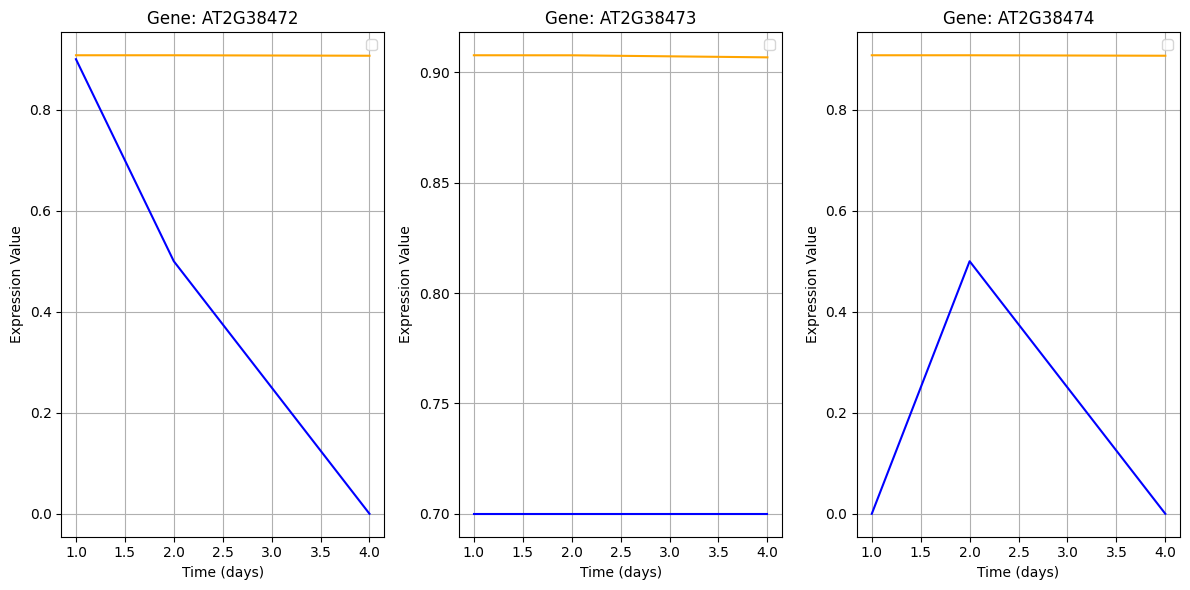

In [57]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)
# test_expression_values = torch.tensor(test_expression_values, dtype=torch.float32)

# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
test_time_points = torch.tensor(test_time_points, dtype=torch.float32, requires_grad=True)
predicted_test_values = model(test_time_points)


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points.detach().numpy(), test_expression_values[i], color="blue")
    plt.plot(test_time_points.detach().numpy(), predicted_test_values[:, 0].detach().numpy(), color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [59]:
# import torch
# import torch.nn as nn
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the neural network
# class NeuralNet(nn.Module):
#     def __init__(self):
#         super(NeuralNet, self).__init__()
#         self.hidden = nn.Sequential(
#             nn.Linear(1, 50),
#             nn.Tanh(),
#             nn.Linear(50, 50),
#             nn.Tanh(),
#             nn.Linear(50, 1)  # Output: y(t)
#         )
#         # Trainable parameters for the ODE
#         self.k_p = nn.Parameter(torch.tensor(1.0, requires_grad=True))
#         self.k_d = nn.Parameter(torch.tensor(1.0, requires_grad=True))

#     def forward(self, t):
#         return self.hidden(t)

# # Define the ODE loss function
# def loss_fn(model, t, y_data, ode_type="linear"):
#     y_pred = model(t)
#     y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

#     if ode_type == "linear":
#         ode_residual = y_t - (model.k_p - model.k_d * y_pred)
#     elif ode_type == "quadratic":
#         ode_residual = y_t - model.k_p * y_pred**2
#     elif ode_type == "sinusoidal":
#         ode_residual = y_t - (model.k_p + model.k_d * torch.sin(y_pred))
#     else:
#         raise ValueError("Unsupported ODE type!")

#     # Physics loss
#     physics_loss = torch.mean(ode_residual**2)

#     # Data loss
#     data_loss = torch.mean((y_pred - y_data)**2)

#     return data_loss + 1.0 * physics_loss

# # Data preprocessing
# t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)
# dataset = {
#     "AT2G3847": torch.tensor([0.906, 0.906, 0.906]),
#     "AT5G4010": torch.tensor([-0.44796, -0.56015, -5.09196]),
#     "AT1G0693": torch.tensor([1.778359, 0, 0]),
#     "AT1G0447": torch.tensor([0, 1.17515, 0]),
#     "AT5G6673": torch.tensor([0.055375, 0.098435, -0.101757])
# }

# ode_types = {
#     "AT2G3847": "linear",
#     "AT5G4010": "linear",
#     "AT1G0693": "quadratic",
#     "AT1G0447": "linear",
#     "AT5G6673": "sinusoidal"
# }

# # Train models for each feature
# models = {}
# for feature, y_data in dataset.items():
#     print(f"Training for {feature}...")
#     y_data = y_data.view(-1, 1)  # Reshape data
#     model = NeuralNet()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#     for epoch in range(1000):
#         optimizer.zero_grad()
#         loss = loss_fn(model, t_data, y_data, ode_types[feature])
#         loss.backward()
#         optimizer.step()
#         if epoch % 100 == 0:
#             print(f"{feature}: Epoch {epoch}, Loss: {loss.item()}")

#     # Store the trained model
#     models[feature] = model
#     print(f"{feature}: Learned k_p = {model.k_p.item()}, k_d = {model.k_d.item()}")

# # Plotting the results
# for feature, y_data in dataset.items():
#     model = models[feature]
#     t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
#     y_pred = model(t_test).detach().numpy()

#     plt.figure()
#     plt.scatter(t_data.detach().numpy(), y_data.numpy(), color='red', label=f'{feature} Data')
#     plt.plot(t_data.detach().numpy(), y_data.detach().numpy(), label='Prediction', color='green')

#     plt.plot(t_test.detach().numpy(), y_pred, label=f'{feature} Prediction', color='blue')

#     plt.title(f'{feature} Dynamics')
#     plt.xlabel('Time')
#     plt.ylabel('y')
#     plt.legend()
#     plt.show()


Epoch 0, Loss: 8.607868194580078
Epoch 100, Loss: 0.028588909655809402
Epoch 200, Loss: 0.006298026069998741
Epoch 300, Loss: 0.0017289966344833374
Epoch 400, Loss: 0.0006591333076357841
Epoch 500, Loss: 8.61997323227115e-05
Epoch 600, Loss: 1.11547142296331e-05
Epoch 700, Loss: 1.1177694432262797e-06
Epoch 800, Loss: 0.00034400896402075887
Epoch 900, Loss: 9.735880439620814e-07
Learned k_p: 0.28082239627838135
Learned k_d: 0.8137990236282349


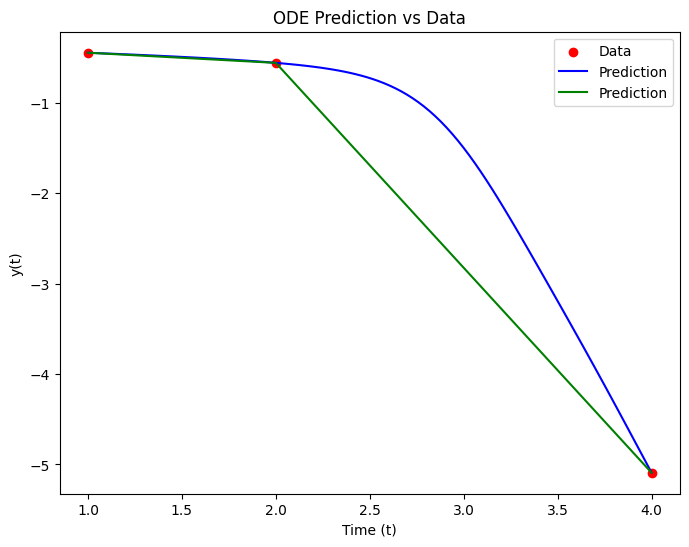

In [60]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: y(t)
        )
        # Trainable parameters for the ODE
        self.k_p = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Forcing term
        self.k_d = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Decay/growth rate

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t)
    y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    # ODE residual
    ode_residual = y_t - (model.k_p + model.k_d * y_pred)

    # Physics loss
    physics_loss = torch.mean(ode_residual**2)

    # Data loss
    data_loss = torch.mean((y_pred - y_data)**2)

    return data_loss + 1.0 * physics_loss

# Data preprocessing
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)  # Time points
y_data = torch.tensor([[-0.44796], [-0.56015], [-5.09196]])      # Corresponding values

# Initialize the model and optimizer
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Output the learned parameters
print(f"Learned k_p: {model.k_p.item()}")
print(f"Learned k_d: {model.k_d.item()}")

# Plotting the data and the prediction
t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
y_pred = model(t_test).detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(t_data.detach().numpy(), y_data.numpy(), color='red', label='Data')
plt.plot(t_test.detach().numpy(), y_pred, label='Prediction', color='blue')
plt.plot(t_data.detach().numpy(), y_data.detach().numpy(), label='Prediction', color='green')


plt.title('ODE Prediction vs Data')
plt.xlabel('Time (t)')
plt.ylabel('y(t)')
plt.legend()
plt.show()


Test Predictions (Predicted):
tensor([[-0.4482],
        [-0.5600],
        [-5.0920]], grad_fn=<AddmmBackward0>)

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


<ipython-input-62-eb27e72f671a>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


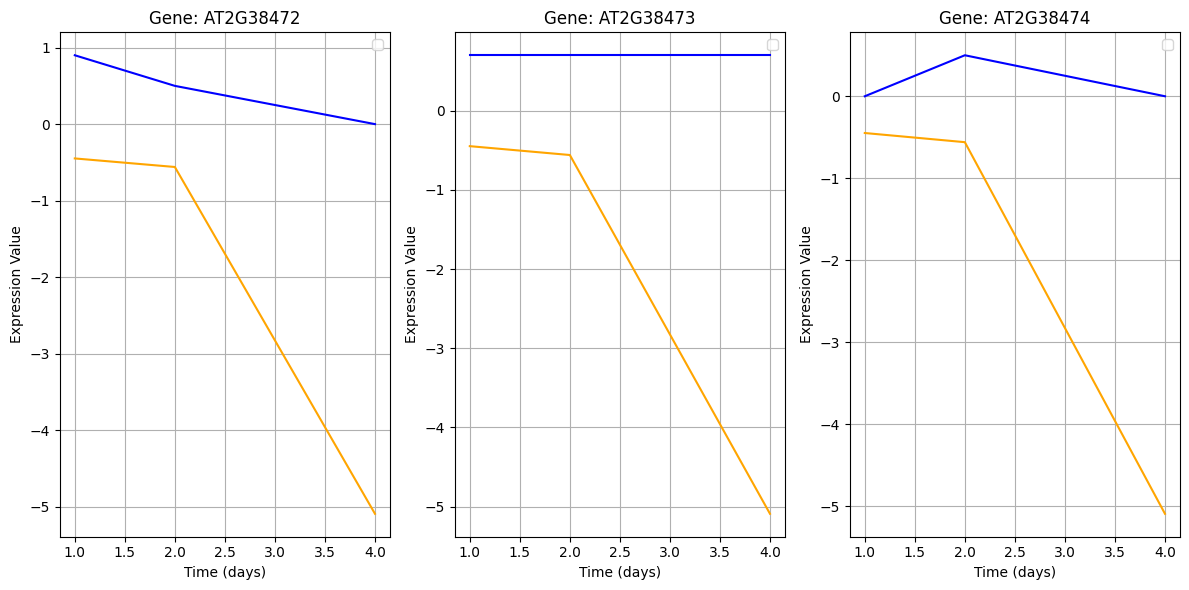

In [62]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)
# test_expression_values = torch.tensor(test_expression_values, dtype=torch.float32)

# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
test_time_points = torch.tensor(test_time_points, dtype=torch.float32)
predicted_test_values = model(test_time_points)


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points.detach().numpy(), test_expression_values[i], color="blue")
    plt.plot(test_time_points.detach().numpy(), predicted_test_values[:, 0].detach().numpy(), color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 0, Loss: 21.21120262145996
Epoch 100, Loss: 0.7040742039680481
Epoch 200, Loss: 0.04190805181860924
Epoch 300, Loss: 0.01605178415775299
Epoch 400, Loss: 0.005288150627166033
Epoch 500, Loss: 0.004682720173150301
Epoch 600, Loss: 0.0047285170294344425
Epoch 700, Loss: 0.00430896133184433
Epoch 800, Loss: 0.0040720985271036625
Epoch 900, Loss: 0.0037241328973323107
ODE 1: Learned k_p: 0.41631224751472473, Learned k_d: 3.8141763525345596e-07
ODE 2: Learned k_p: 0.25330913066864014, Learned k_d: -1.0771825600386364e-06
ODE 3: Learned k_p: 0.5128682851791382, Learned k_d: -1.532110616153659e-07
ODE 4: Learned k_p: 0.390987366437912, Learned k_d: 0.8926736116409302
ODE 5: Learned k_p: 0.38142624497413635, Learned k_d: 0.3839975595474243
ODE 6: Learned k_p: 0.33278152346611023, Learned k_d: -2.3737154606351396e-06
ODE 7: Learned k_p: 0.35938265919685364, Learned k_d: 0.2712066173553467
ODE 8: Learned k_p: 0.4193686246871948, Learned k_d: 1.169985353044467e-06
ODE 9: Learned k_p: 0.3903

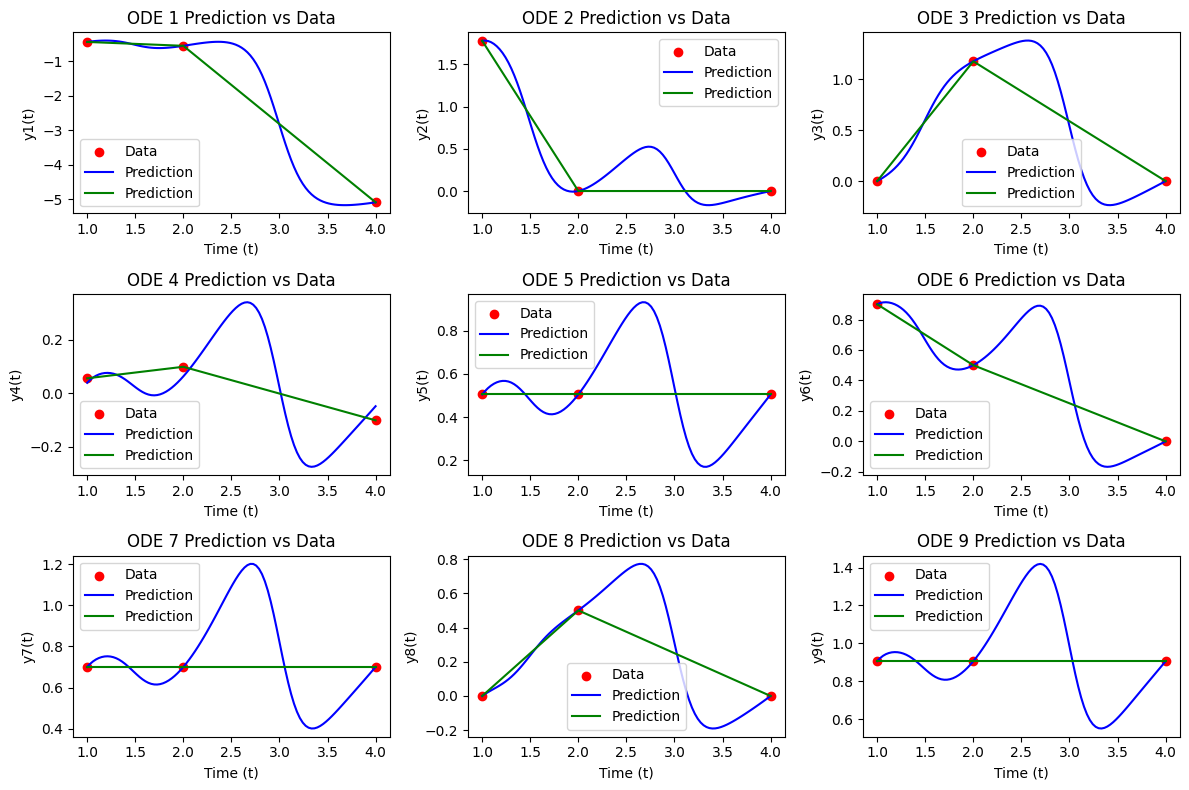

In [63]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, num_odes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, num_odes)  # Output: y(t) for each ODE
        )
        # Trainable parameters for each ODE
        self.k_p = nn.Parameter(torch.ones(num_odes))  # Forcing terms
        self.k_d = nn.Parameter(torch.ones(num_odes))  # Decay/growth rates

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t)  # Predicted outputs (all ODEs)
    num_odes = y_data.shape[1]

    # Compute derivatives and ODE residuals
    losses = []
    for i in range(num_odes):
        y_i_pred = y_pred[:, i]
        y_i_t = torch.autograd.grad(
            y_i_pred, t, grad_outputs=torch.ones_like(y_i_pred), create_graph=True
        )[0]
        # ODE residual for the i-th ODE
        ode_residual = y_i_t - (model.k_p[i] + model.k_d[i] * y_i_pred)

        # Physics loss
        physics_loss = torch.mean(ode_residual**2)

        # Data loss
        data_loss = torch.mean((y_i_pred - y_data[:, i])**2)

        # Total loss for the i-th ODE
        losses.append(data_loss + 1.0 * physics_loss)

    # Sum losses for all ODEs
    return sum(losses)

# Data preprocessing
# Define time points (t_data) and the data matrix (y_data)
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)  # Time points
y_data = torch.tensor([
    [-0.44796, -0.56015, -5.09196],
    [1.77836, 0.0, 0.0],
    [0.0, 1.17515, 0.0],
    [0.05537, 0.09843, -0.10176],
    [0.505, 0.505, 0.505],
    [0.9, 0.5, 0.0],
    [0.7, 0.7, 0.7],
    [0.0, 0.5, 0.0],
    [0.906, 0.906, 0.906]
]).T  # Transpose to have columns for ODEs

# Initialize the model and optimizer
num_odes = y_data.shape[1]
model = NeuralNet(num_odes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Output the learned parameters
for i in range(num_odes):
    print(f"ODE {i+1}: Learned k_p: {model.k_p[i].item()}, Learned k_d: {model.k_d[i].item()}")

# Plotting the data and the prediction for each ODE
t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
y_pred = model(t_test).detach().numpy()

plt.figure(figsize=(12, 8))
for i in range(num_odes):
    plt.subplot(3, 3, i+1)  # Create a subplot for each ODE
    plt.scatter(t_data.detach().numpy(), y_data[:, i].numpy(), color='red', label='Data')
    plt.plot(t_test.detach().numpy(), y_pred[:, i], label='Prediction', color='blue')
    plt.plot(t_data.detach().numpy(), y_data[:, i], label='Prediction', color='green')

    plt.title(f'ODE {i+1} Prediction vs Data')
    plt.xlabel('Time (t)')
    plt.ylabel(f'y{i+1}(t)')
    plt.legend()

plt.tight_layout()
plt.show()


Test Predictions (Predicted):
tensor([[-4.4796e-01,  1.7784e+00,  9.8720e-07,  3.8537e-02,  5.0500e-01,
          9.0000e-01,  7.0000e-01,  1.2740e-06,  9.0600e-01],
        [-5.6015e-01,  7.8529e-06,  1.1752e+00,  6.2459e-02,  5.0500e-01,
          5.0000e-01,  7.0001e-01,  5.0000e-01,  9.0601e-01],
        [-5.0920e+00,  1.6540e-06,  1.7509e-06, -4.8917e-02,  5.0500e-01,
          4.5747e-06,  7.0001e-01,  2.7195e-06,  9.0600e-01]],
       grad_fn=<AddmmBackward0>)

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


<ipython-input-64-eb27e72f671a>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


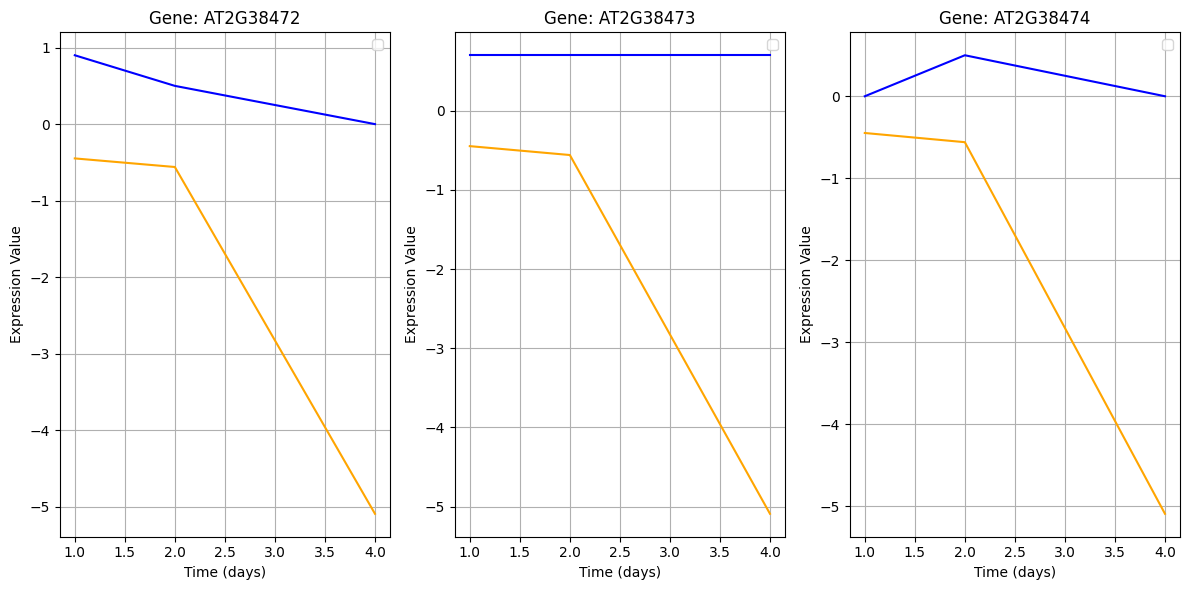

In [64]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)
# test_expression_values = torch.tensor(test_expression_values, dtype=torch.float32)

# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
test_time_points = torch.tensor(test_time_points, dtype=torch.float32)
predicted_test_values = model(test_time_points)


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points.detach().numpy(), test_expression_values[i], color="blue")
    plt.plot(test_time_points.detach().numpy(), predicted_test_values[:, 0].detach().numpy(), color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [67]:
model.k_d

Parameter containing:
tensor([ 3.8142e-07, -1.0772e-06, -1.5321e-07,  8.9267e-01,  3.8400e-01,
        -2.3737e-06,  2.7121e-01,  1.1700e-06,  2.4627e-01],
       requires_grad=True)

AT5G40100 - Epoch 0, Loss: 9.318127632141113
AT5G40100 - Epoch 100, Loss: 0.037233129143714905
AT5G40100 - Epoch 200, Loss: 6.384636321854487e-07
AT5G40100 - Epoch 300, Loss: 1.3079217396627651e-11
AT5G40100 - Epoch 400, Loss: 4.934324789176514e-16
AT5G40100 - Epoch 500, Loss: 0.0
AT5G40100 - Epoch 600, Loss: 0.0
AT5G40100 - Epoch 700, Loss: 0.0
AT5G40100 - Epoch 800, Loss: 0.0
AT5G40100 - Epoch 900, Loss: 0.0


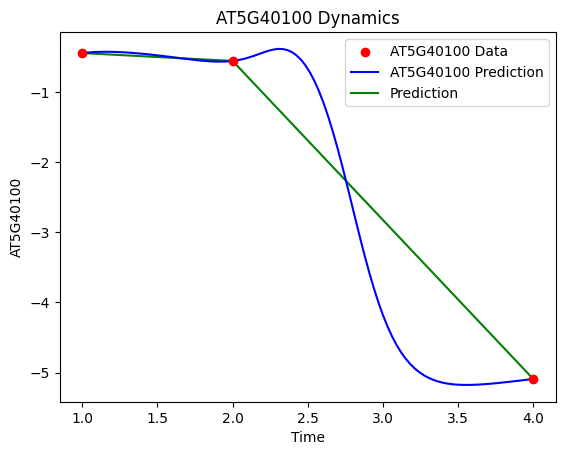

AT1G06930 - Epoch 0, Loss: 1.0487340688705444
AT1G06930 - Epoch 100, Loss: 0.46181800961494446
AT1G06930 - Epoch 200, Loss: 0.1318502277135849
AT1G06930 - Epoch 300, Loss: 0.0014831682201474905
AT1G06930 - Epoch 400, Loss: 1.274216720048571e-05
AT1G06930 - Epoch 500, Loss: 4.37090470484236e-08
AT1G06930 - Epoch 600, Loss: 6.562505400209417e-11
AT1G06930 - Epoch 700, Loss: 1.1214884272983672e-13
AT1G06930 - Epoch 800, Loss: 1.0111383810047694e-14
AT1G06930 - Epoch 900, Loss: 6.752591654136605e-16


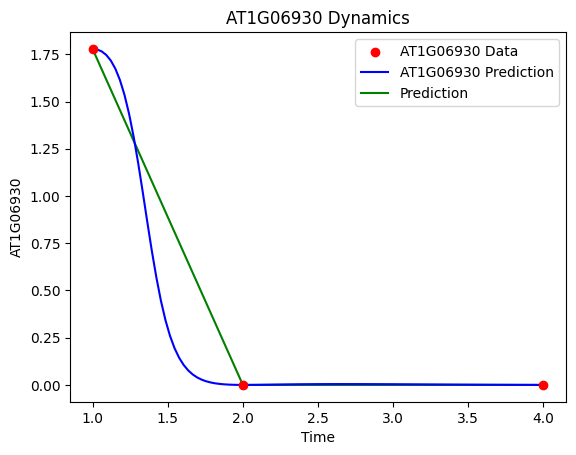

AT1G04470 - Epoch 0, Loss: 2.870182752609253
AT1G04470 - Epoch 100, Loss: 0.23330768942832947
AT1G04470 - Epoch 200, Loss: 0.13268330693244934
AT1G04470 - Epoch 300, Loss: 0.004792236257344484
AT1G04470 - Epoch 400, Loss: 1.3863169101568928e-07
AT1G04470 - Epoch 500, Loss: 1.7428650753506525e-12
AT1G04470 - Epoch 600, Loss: 1.295260124809937e-15
AT1G04470 - Epoch 700, Loss: 5.440092820663267e-15
AT1G04470 - Epoch 800, Loss: 6.772360450213455e-15
AT1G04470 - Epoch 900, Loss: 2.081174723658416e-13


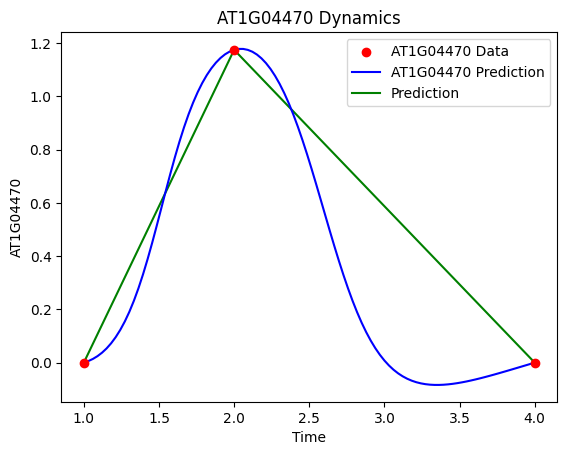

AT5G66730 - Epoch 0, Loss: 0.5790841579437256
AT5G66730 - Epoch 100, Loss: 0.057346899062395096
AT5G66730 - Epoch 200, Loss: 0.00929578673094511
AT5G66730 - Epoch 300, Loss: 0.005710320547223091
AT5G66730 - Epoch 400, Loss: 0.005345839541405439
AT5G66730 - Epoch 500, Loss: 0.005102597177028656
AT5G66730 - Epoch 600, Loss: 0.004908796865493059
AT5G66730 - Epoch 700, Loss: 0.004766160622239113
AT5G66730 - Epoch 800, Loss: 0.0046312035992741585
AT5G66730 - Epoch 900, Loss: 0.004500573966652155


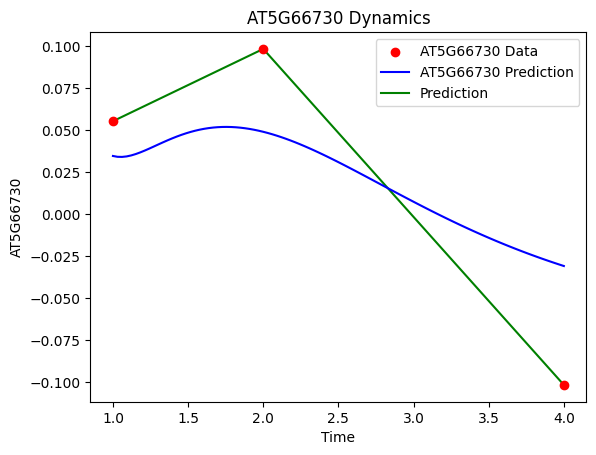

AT2G38471 - Epoch 0, Loss: 1.218288779258728
AT2G38471 - Epoch 100, Loss: 0.0007538379868492484
AT2G38471 - Epoch 200, Loss: 3.4788849006872624e-05
AT2G38471 - Epoch 300, Loss: 1.1363050361978821e-05
AT2G38471 - Epoch 400, Loss: 3.66647122973518e-06
AT2G38471 - Epoch 500, Loss: 1.481061303820752e-06
AT2G38471 - Epoch 600, Loss: 9.145321087089542e-07
AT2G38471 - Epoch 700, Loss: 7.333044322876958e-07
AT2G38471 - Epoch 800, Loss: 6.27842723588401e-07
AT2G38471 - Epoch 900, Loss: 5.379646381697967e-07


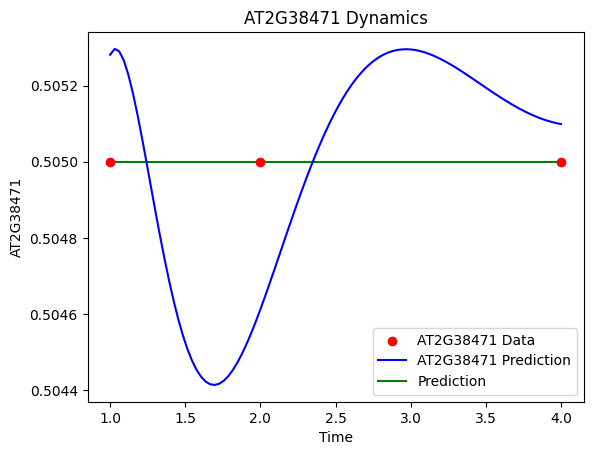

AT2G38472 - Epoch 0, Loss: 3.319035768508911
AT2G38472 - Epoch 100, Loss: 0.08772551268339157
AT2G38472 - Epoch 200, Loss: 0.07788980007171631
AT2G38472 - Epoch 300, Loss: 0.06556269526481628
AT2G38472 - Epoch 400, Loss: 0.04407674819231033
AT2G38472 - Epoch 500, Loss: 0.015968387946486473
AT2G38472 - Epoch 600, Loss: 0.0022336735855787992
AT2G38472 - Epoch 700, Loss: 2.218440204160288e-05
AT2G38472 - Epoch 800, Loss: 1.1925818910185626e-07
AT2G38472 - Epoch 900, Loss: 3.581400176422278e-10


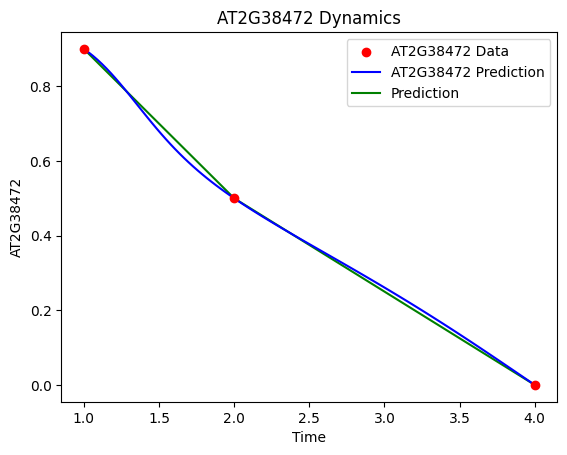

AT2G38473 - Epoch 0, Loss: 3.5721435546875
AT2G38473 - Epoch 100, Loss: 0.0007911366992630064
AT2G38473 - Epoch 200, Loss: 1.948979843291454e-06
AT2G38473 - Epoch 300, Loss: 1.053253186000802e-06
AT2G38473 - Epoch 400, Loss: 7.972441835590871e-07
AT2G38473 - Epoch 500, Loss: 6.977999760238163e-07
AT2G38473 - Epoch 600, Loss: 6.358667974382115e-07
AT2G38473 - Epoch 700, Loss: 5.827855602547061e-07
AT2G38473 - Epoch 800, Loss: 5.323556706571253e-07
AT2G38473 - Epoch 900, Loss: 4.842678436034475e-07


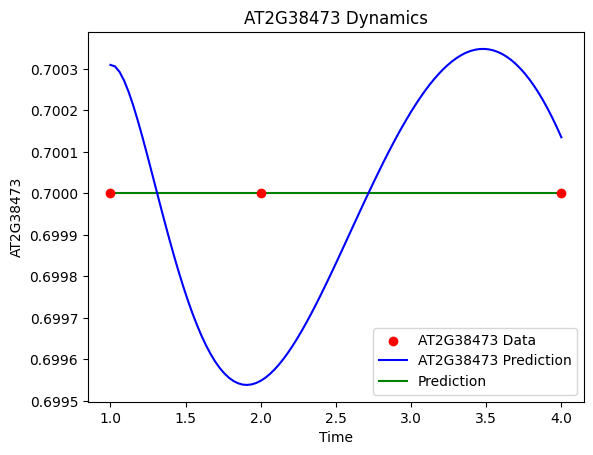

AT2G38474 - Epoch 0, Loss: 2.261260986328125
AT2G38474 - Epoch 100, Loss: 0.0721818134188652
AT2G38474 - Epoch 200, Loss: 0.047951407730579376
AT2G38474 - Epoch 300, Loss: 0.04032088816165924
AT2G38474 - Epoch 400, Loss: 0.034044548869132996
AT2G38474 - Epoch 500, Loss: 0.02873886376619339
AT2G38474 - Epoch 600, Loss: 0.018833879381418228
AT2G38474 - Epoch 700, Loss: 0.005051353480666876
AT2G38474 - Epoch 800, Loss: 0.0002498202957212925
AT2G38474 - Epoch 900, Loss: 4.714992883236846e-06


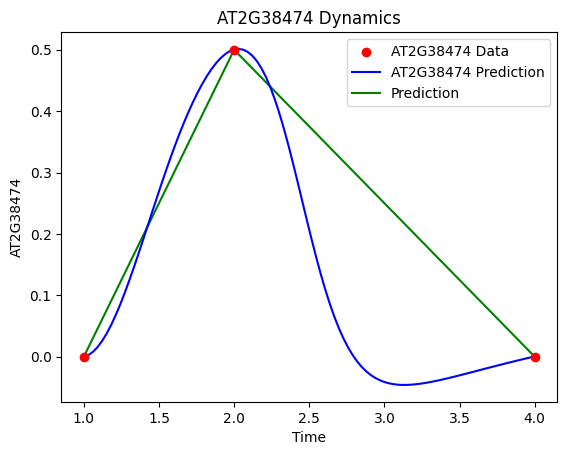

AT2G38470 - Epoch 0, Loss: 2.253368377685547
AT2G38470 - Epoch 100, Loss: 3.267832289566286e-05
AT2G38470 - Epoch 200, Loss: 6.068245511414716e-06
AT2G38470 - Epoch 300, Loss: 4.926905603497289e-06
AT2G38470 - Epoch 400, Loss: 3.901447598764207e-06
AT2G38470 - Epoch 500, Loss: 3.025311116289231e-06
AT2G38470 - Epoch 600, Loss: 2.3055702058627503e-06
AT2G38470 - Epoch 700, Loss: 1.7300098988926038e-06
AT2G38470 - Epoch 800, Loss: 1.2782243175024632e-06
AT2G38470 - Epoch 900, Loss: 9.293107723351568e-07


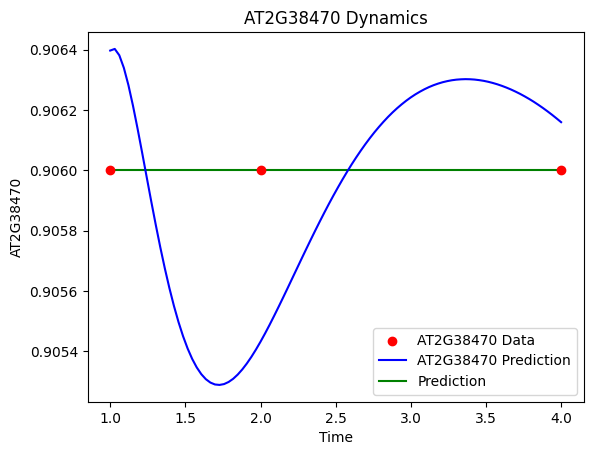

AT5G40100: k = -0.000000, c = 0.254054
AT1G06930: k = 0.000000, c = -0.002144
AT1G04470: k = 0.000000, c = 0.167126
AT5G66730: k = 1.194862, c = -0.003886
AT2G38471: k = 1.234542, c = 0.624077
AT2G38472: k = 0.000002, c = -0.275039
AT2G38473: k = 1.072050, c = 0.750244
AT2G38474: k = 0.000663, c = 0.057374
AT2G38470: k = 0.981271, c = 0.889412


In [70]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Single output: y
        )
        # Trainable parameters
        self.k = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t).squeeze()

    # Compute derivatives
    y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    # ODE residuals
    ode_residual = y_t + model.k * y_pred - model.c

    # Physics loss
    physics_loss = torch.mean(ode_residual**2)

    # Data loss
    data_loss = torch.mean((y_pred - y_data)**2)

    return data_loss + 1.0 * physics_loss

# Data: Replace with the given dataset
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points
time_points = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)

# Initialize results
results = {}

for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)

    # Initialize model and optimizer
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    for epoch in range(1000):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item()}")

    # Save the learned parameters
    results[gene] = {
        "k": model.k.item(),
        "c": model.c.item()
    }

    # Generate predictions for plotting
    t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
    y_pred = model(t_test).detach().numpy()

    # Plotting the results
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(t_test.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)
    plt.plot(time_points.detach().numpy(), y_data.detach().numpy(), label='Prediction', color='green', zorder=3)
    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print results
for gene, params in results.items():
    print(f"{gene}: k = {params['k']:.6f}, c = {params['c']:.6f}")


Test Predictions (Predicted):
tensor([[0.9064],
        [0.9054],
        [0.9062]], grad_fn=<AddmmBackward0>)

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


<ipython-input-71-63e9ca9cd519>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


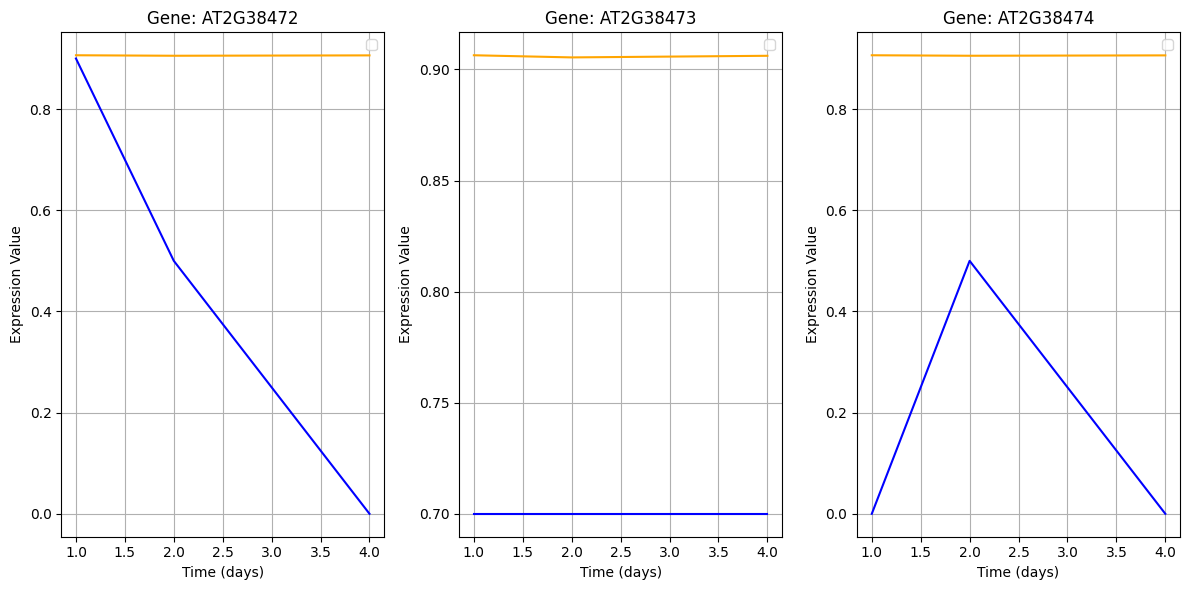

In [71]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)


# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
test_time_points = torch.tensor(test_time_points, dtype=torch.float32, requires_grad=True)
predicted_test_values = model(test_time_points)


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points.detach().numpy(), test_expression_values[i], color="blue")
    plt.plot(test_time_points.detach().numpy(), predicted_test_values[:, 0].detach().numpy(), color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
